# Model Training

## 1. Import packages and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_validate

In [2]:
filepath= "./jpn-hostel-data/clean.csv"
df = pd.read_csv(filepath)

In [3]:
df.head()

,City,price.from,summary.score,rating.band,atmosphere,cleanliness,facilities,location.y,security,staff,valueformoney,distance_km
0,Osaka,3300,9.2,Superb,8.9,9.4,9.3,8.9,9.0,9.4,9.4,2.9
1,Fukuoka-City,2600,9.5,Superb,9.4,9.7,9.5,9.7,9.2,9.7,9.5,0.7
2,Tokyo,3600,8.7,Fabulous,8.0,7.0,9.0,8.0,10.0,10.0,9.0,7.8
3,Tokyo,2600,7.4,Very Good,8.0,7.5,7.5,7.5,7.0,8.0,6.5,8.7
4,Tokyo,1500,9.4,Superb,9.5,9.5,9.0,9.0,9.5,10.0,9.5,10.5


## 2. Split train and test data

In [4]:
X = df.drop(columns=['price.from'], axis=1)
X.head()

,City,summary.score,rating.band,atmosphere,cleanliness,facilities,location.y,security,staff,valueformoney,distance_km
0,Osaka,9.2,Superb,8.9,9.4,9.3,8.9,9.0,9.4,9.4,2.9
1,Fukuoka-City,9.5,Superb,9.4,9.7,9.5,9.7,9.2,9.7,9.5,0.7
2,Tokyo,8.7,Fabulous,8.0,7.0,9.0,8.0,10.0,10.0,9.0,7.8
3,Tokyo,7.4,Very Good,8.0,7.5,7.5,7.5,7.0,8.0,6.5,8.7
4,Tokyo,9.4,Superb,9.5,9.5,9.0,9.0,9.5,10.0,9.5,10.5


In [5]:
y = df['price.from']
print(y)

0      3300
1      2600
2      3600
3      2600
4      1500
       ... 
334    2300
335    2000
336    2500
337    2800
338    2900
Name: price.from, Length: 339, dtype: int64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("Train data shape:", X_train.shape)
print("Test data shape",X_test.shape)

Train data shape: (271, 11)
Test data shape (68, 11)


## 3. Prepare Transformer

In [7]:
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

numeric_transformer = RobustScaler()
ohe_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", ohe_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ],
    remainder='drop'
)

## 4. Model creation

In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

scoring = {
    'mae':  make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

scoreboard=pd.DataFrame(columns=[
    'Model', 
    'Avg MAE',
    'Avg R2'
])

In [9]:
def get_model_cross_val(pipeline, X, y, metrics):
    cv_results = cross_validate(pipeline, X, y, scoring = metrics)
    
    mae_score = -round(cv_results['test_mae'].mean(), 2)
    
    r_squared_score = round(cv_results['test_r2'].mean(), 2)
    
    model_name= pipeline.named_steps['model'].__class__.__name__
        
    data = [(model_name, mae_score, r_squared_score)]
    model_scores = pd.DataFrame(data = data, columns=[
    'Model', 
    'Avg MAE',
    'Avg R2'
])
    
    return model_scores

scoreboard.drop(scoreboard.index,inplace=True)

In [10]:
for model in models.values():
    pipeline = Pipeline([
        ('transformer', preprocessor),
        ('model', model)
    ])
    model_scores = get_model_cross_val(pipeline, X_train, y_train, scoring)
    scoreboard = pd.concat([scoreboard, model_scores], ignore_index=True)

/opt/conda/envs/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.966e+06, tolerance: 1.504e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/envs/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.750e+06, tolerance: 1.437e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/envs/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2

In [11]:
scoreboard

,Model,Avg MAE,Avg R2
0,LinearRegression,608.29,0.05
1,Lasso,600.73,0.07
2,Ridge,597.47,0.08
3,KNeighborsRegressor,580.21,0.11
4,RandomForestRegressor,573.69,0.12
5,XGBRegressor,604.77,0.06
6,CatBoostRegressor,583.51,0.16
7,AdaBoostRegressor,594.15,0.10


## 5. Model evaluation
CatBoost Regressor has better results than the others.

In [12]:
model = CatBoostRegressor(verbose=False, random_state=42)
pipeline = Pipeline([
        ('transformer', preprocessor),
        ('model', model)
    ])

In [13]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

In [14]:
mae_score = round(mean_absolute_error(y_test, y_pred), 2)
r_squared_score = round(r2_score(y_test, y_pred), 2)

print("MAE:", mae_score)
print("R2:", r_squared_score)

MAE: 579.49
R2: -0.02


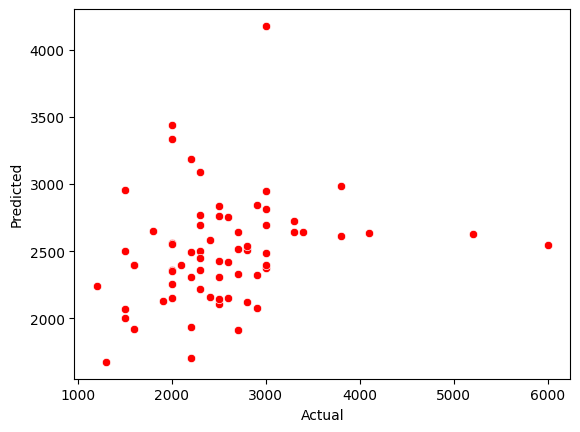

In [15]:
sns.scatterplot(x=y_test,y=y_pred, color ='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [16]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
284,2900,2320.074446,579.925554
116,2300,2361.307415,-61.307415
113,3300,2642.838644,657.161356
42,2200,2491.065324,-291.065324
126,3800,2610.841644,1189.158356
...,...,...,...
173,1600,1921.361426,-321.361426
208,2300,2770.594643,-470.594643
72,2300,2448.687199,-148.687199
75,2800,2121.718179,678.281821


### 6. Observations
- Given the range of prices, a Mean Absolute Error (MAE) of 580 seems somewhat significant.
- The low R-squared value (0.16) in the training data indicates that the model explains only 16% of the variance. Moreover, the negative R-squared in the evaluation suggests that the model's guesses are random.
- Most probably the model is underfitting.